In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os, sys
import optax
import itertools
import equinox as eqx
import jax.numpy as jnp
import scipy.stats as st
import matplotlib.pyplot as plt

from time import time
from utilities import *
from tqdm import tqdm
from jax import device_put
from functools import partial
from IPython import display
from transforms import utilities, cheb
from collections import namedtuple
from jax.lax import scan, dot_general
from architectures import DilResNet, fSNO, UNet, ChebNO
from jax import config, random, grad, vmap, tree_map, tree_leaves, jit
from jax.experimental import sparse as jsparse

config.update("jax_enable_x64", True)

os.environ["CUDA_VISIBLE_DEVICES"] = '2'

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Dataset

We are solving BVP in 2D

\begin{equation}
    - \Delta u = f(x), \quad u\big|_{\partial G} = 0, ~G = [0,~1] \times [0, ~1]
\end{equation}

In [3]:
grid = 32
N_samples = 50

info = namedtuple('info', ['grid', 'N_samples'])
args = info(grid=grid, N_samples=N_samples)

In [4]:
def random_polynomial_2D(x, y, coeff):
    res = 0
    for i, j in itertools.product(range(coeff.shape[0]), repeat=2):
        res += coeff[i, j]*jnp.exp(2*jnp.pi*x*i*1j)*jnp.exp(2*jnp.pi*y*j*1j)/(1+i+j)**2
    res = jnp.real(res)
    return res

def get_functions(key):
    c_ = random.normal(key, (1, 5, 5), dtype=jnp.complex128)
    rhs = lambda x, y, c=c_[0]: random_polynomial_2D(x, y, c)
    return rhs

@partial(jit)
def get_dataset(state, key, N_points):
    rhs = state[0]
    rhs = get_functions(key)
    
    x = jnp.linspace(0, 1, num=args.grid, endpoint=False)
    y = jnp.linspace(0, 1, num=args.grid, endpoint=False)

    xx, yy = jnp.meshgrid(x, y)
    
    state = [rhs(xx, yy)]
    return state, state

In [5]:
key = random.PRNGKey(42)

dataset = partial(get_dataset, N_points=args.grid)
features = [jnp.zeros(shape=(args.grid, args.grid))]
initial = features

_, dataset = scan(dataset, initial, random.split(key, args.N_samples))

In [6]:
A = [jsparse.BCOO.from_scipy_sparse(poisson((args.grid, args.grid), ax=1, ay=1).to_csr()).reshape(1, args.grid**2, -1) for i in range(args.N_samples)]
A = device_put(jsparse.bcoo_concatenate(A, dimension=0))
A.shape

(50, 1024, 1024)

In [7]:
@partial(jit)
def spsolve_scan(carry, n):
    A, r = carry
    A_bcsr = jsparse.BCSR.from_bcoo(A)
    Ar = jsparse.linalg.spsolve(A_bcsr.data[n], A_bcsr.indices[n], A_bcsr.indptr[n], r[n])
    return [A, r], Ar

def res_func(A, B, res, analysis, synthesis):
    _, Ar = scan(spsolve_scan, [A, res], jnp.arange(A.shape[0]))
    Ar = jnp.array(Ar)
    B_Ar = jsparse.bcoo_dot_general(A, B - Ar, dimension_numbers=((2, 1), (0, 0)))
    numerator = jnp.sqrt(jnp.einsum('bi, bi -> b', B - Ar, B_Ar))
    denominator = jnp.sqrt(jnp.einsum('bi, bi -> b', Ar, res))
    value = numerator / denominator
    return value

In [8]:
def compute_loss(model, A, x, analysis, synthesis):
    B = vmap(lambda z: model(z, analysis, synthesis), in_axes=(0,))(x[:, None, :])[:, 0].reshape(x.shape[0], -1)
    x_reshaped = x.reshape(x.shape[0], -1)
    _, Ar = scan(spsolve_scan, [A, x_reshaped], jnp.arange(A.shape[0]))
    Ar = jnp.array(Ar)
    B_Ar = jsparse.bcoo_dot_general(A, B - Ar, dimension_numbers=((2, 1), (0, 0)))
    return jnp.mean(jnp.sqrt(jnp.einsum('bi, bi -> b', B - Ar, B_Ar) / jnp.einsum('bi, bi -> b', Ar, x.reshape(x.shape[0], -1))))

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step_scan(carry, indices, optim, analysis, synthesis):
    model, A, x, opt_state, N_repeats = carry
    loss, grads = compute_loss_and_grads(model, A[indices // N_repeats], x[indices], analysis, synthesis)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return [model, A, x, opt_state, N_repeats], loss

In [9]:
def train_on_epoch(key, batch_size, A, model, x, opt_state, make_step, N_repeats):
    N_samples = len(x)
    list_of_indices = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)

    n_batches = N_samples // batch_size
    
    carry = [model, A, x, opt_state, N_repeats]
    n = random.choice(key, list_of_indices, shape = (n_batches, batch_size))

    data, epoch_loss = scan(make_step, carry, n)
    model = data[0]
    opt_state = data[3]

    return epoch_loss, model, opt_state

def train_model(model, A, x, optimization_specification, N_repeats):
    model = model
    history = []

    c = x.shape[0] // optimization_specification['batch_size']
    keys = [value * c for value in np.arange(50, 1000, 50)]
    values = [0.5, ] * len(keys)
    dict_lr = dict(zip(keys, values))

    sc = optax.piecewise_constant_schedule(optimization_specification['learning_rate'], dict_lr)
    optimizer = optax.adamw(sc, weight_decay=1e-2)

    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    make_step = lambda a, b: optimization_specification['make_step'](a, b, optimizer)
    
    for it in tqdm(range(optimization_specification['N_epochs'])):
        key = random.PRNGKey(it)
        loss, model, opt_state = train_on_epoch(key, optimization_specification['batch_size'], A, model, x, opt_state, make_step, N_repeats)
        history.append(loss)
        
    return model, history

In [10]:
def get_SNO(key, features_train):
    input = features_train
    D = len(input.shape[1:])
    
    # Parameters of model
    polynomials = ["Real_Fourier", ] * D
    parameters = [[0.1, 0.1],] * D
    M_keep = [20, ] * D
    N_points = input.shape[1:]
    grids = N_points
    
    data = {
        "polynomials": polynomials,
        "parameters": parameters,
        "grids": grids,
        "M_keep": M_keep,
        "N_points": N_points
    }
    
    synthesis = utilities.get_operators("synthesis", **data)
    analysis = utilities.get_operators("analysis", **data)
    
    kernel_size = 3
    n_conv_layers = 3
    cell = lambda features, key: DilResNet.DilatedConvBlock([features,]*(n_conv_layers + 1), [[1,]*D, ]*n_conv_layers, [[kernel_size,]*D, ]*n_conv_layers, key, activation=lambda x: x)
    
    input_shape = input.shape
    N_features_out = 1
    N_features = 32
    N_layers = 4

    model = fSNO.fSNO(input_shape, N_features_out, N_layers, N_features, cell, key)
    
    # Parameters of training
    N_epoch = 100
    batch_size = 32
    learning_rate = 1e-3
    
    model_data = {
        "model_name": "fSNO",
        "model": model,
        "analysis": analysis,
        "synthesis": synthesis
        }
    
    optimization_specification = {
        "learning_rate": learning_rate,
        "compute_loss": lambda model, A, input: compute_loss(model, A, input, analysis, synthesis),
        "make_step": lambda carry, indices, optim: make_step_scan(carry, indices, optim, analysis, synthesis),
        "N_epochs": N_epoch,
        "batch_size": batch_size, 
        "res_func": lambda A, model, input: res_func(A, model, input, analysis, synthesis) 
    }
    return model_data, optimization_specification

In [11]:
N_samples_model = 50

f = dataset[0]
X = random.normal(random.PRNGKey(42), (args.N_samples, N_samples_model, args.grid * args.grid)).reshape((args.N_samples, N_samples_model, -1))
X.shape, f.shape

((50, 50, 1024), (50, 32, 32))

In [12]:
residuals = (jnp.repeat(f[:, None], N_samples_model, axis=1).reshape(args.N_samples, N_samples_model, -1) - jsparse.bcoo_dot_general(A, X, dimension_numbers=((2, 2),(0, 0))).transpose((0,2,1))).reshape((args.N_samples * N_samples_model, -1, args.grid))
residuals = jnp.einsum('bij, b -> bij', residuals, 1./jnp.linalg.norm(residuals, axis=(1, 2)))
residuals.shape

(2500, 32, 32)

In [13]:
model_data, optimization_specification = get_SNO(random.PRNGKey(42), residuals[0][None, ...])
model, history = train_model(model_data['model'], A, residuals, optimization_specification, N_samples_model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:01:30<00:00, 36.91s/it]


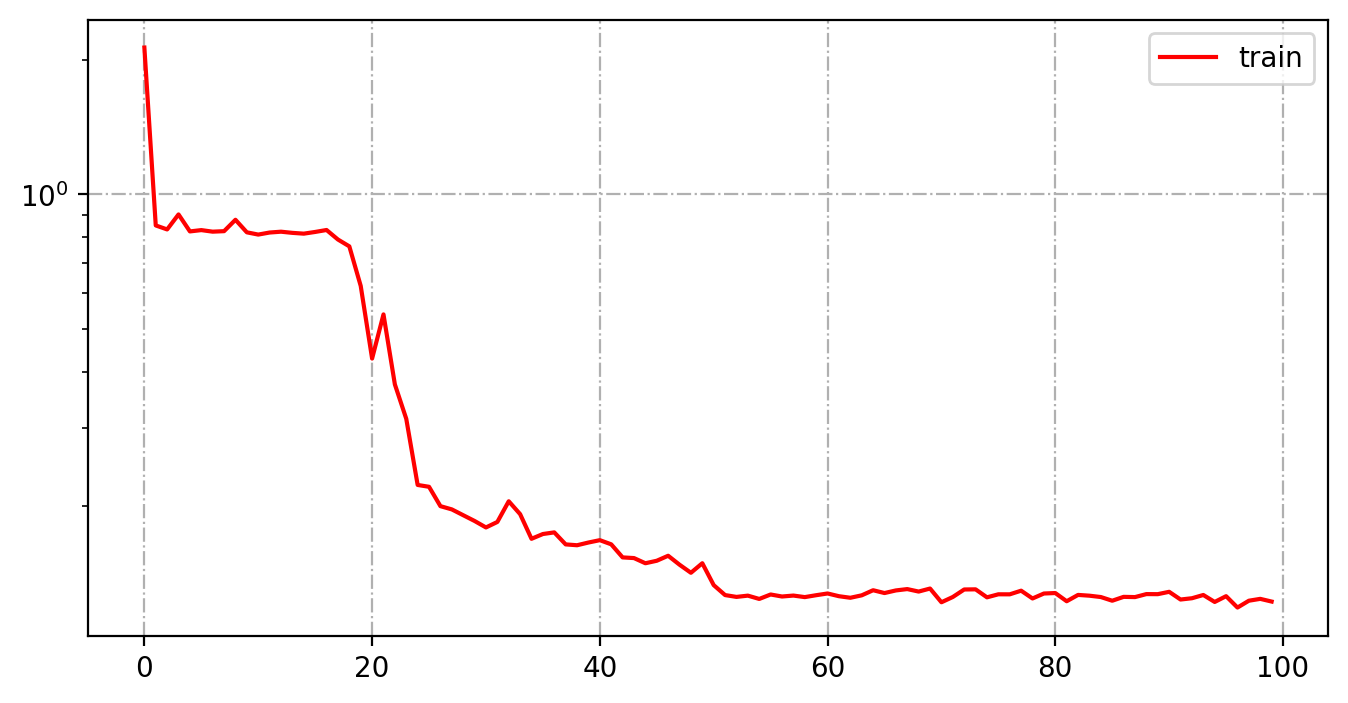

In [14]:
fig = plt.figure(figsize=(8, 4))

plt.plot([jnp.mean(jnp.array(epoch)) for epoch in history], color='red', label=r'train')
plt.yscale('log')
plt.legend(loc='best')
plt.grid(linestyle='-.');

In [15]:
def FCG(A, features, targets, model, N_iter, m_max, optimization_specification, eps=1e-30):
    def get_mi(i, m_max):
        if i == 0:
            return 0
        else:
            return jnp.maximum(1, i % (m_max+1))

    samples = targets.shape[0]
    n = targets.shape[-1]

    X, U, P = jnp.zeros((samples, n, N_iter+1)),  jnp.zeros((samples, n, N_iter)), jnp.zeros((samples, n, N_iter))
    R = jnp.zeros((samples, n, N_iter+1))
    S, Gamma, Eta, Alpha = jnp.zeros((samples, n, N_iter)), jnp.zeros((samples, N_iter)), jnp.zeros((samples, N_iter)), jnp.zeros((samples, N_iter))
    x0 = random.normal(random.PRNGKey(2), (samples, n)) / 10

    X = X.at[:, :, 0].set(x0)
    f = features
    R = R.at[:, :, 0].set(f - jsparse.bcoo_dot_general(A, x0, dimension_numbers=((2, 1),(0, 0))))
    train_losses, train_residuals = [], []
    train_residuals_std = []

    h = 1. / args.grid

    values, values_std = [], []

    for idx in range(N_iter):
        train_residuals.append((jnp.linalg.norm(R[:, :, idx], axis=1) / jnp.linalg.norm(f, axis=1)).mean())
        train_residuals_std.append(st.t.interval(confidence=0.99, df=len(jnp.linalg.norm(R[:, :, idx], axis=1))-1, 
                                                 loc=train_residuals[-1], scale=st.sem((jnp.linalg.norm(R[:, :, idx], axis=1) / jnp.linalg.norm(f, axis=1)))))
        train_losses.append((jnp.linalg.norm(X[:, :, idx] * h ** 2 - targets, axis=1) / jnp.linalg.norm(targets, axis=1)).mean())

        norm = jnp.linalg.norm(R[:, :, idx], axis=1)
        
        train_data = [jnp.einsum('bi,b->bi', R[:, :, idx], 1/norm)]
        if type(model) != type(lambda x: x):
            model, history_train = train_model(model,  A, train_data[0].reshape(-1, args.grid, args.grid), optimization_specification, 1)
#             optimization_specification['learning_rate'] *= 0.85
   
            output = vmap(model, in_axes=(0, None, None))(jnp.einsum('bi, b->bi', R[:, :, idx], 1/norm)[:, None].reshape(-1, 1, args.grid, args.grid), model_data["analysis"], model_data["synthesis"])[:, 0].reshape(-1, args.grid**2)
            U = U.at[:, :, idx].set(jnp.einsum('bi, b->bi', output, norm))

        else:
            history_train = []
            U = U.at[:, :, idx].set(vmap(model)(R[:, :, idx]))

        value = optimization_specification['res_func'](A,  U[:, :, idx], R[:, :, idx])
        
        values.append(value.mean())
        values_std.append(st.t.interval(confidence=0.99, df=len(value)-1, 
                                                 loc=values[-1], scale=st.sem(value)))

        j = get_mi(idx, m_max)
        P = P.at[:, :, idx].set(U[:, :, idx])
        for k in range(j):
            alpha = -jnp.einsum('bj, bj->b', S[:, :, idx-k-1], P[:, :, idx]) / (jnp.einsum('bj, bj->b', S[:, :, idx-k-1], P[:, :, idx-k-1]) + eps)
            P = P.at[:, :, idx].add(jnp.einsum('b, bj->bj', alpha, P[:, :, idx-k-1]))
        
        S = S.at[:, :, idx].set(jsparse.bcoo_dot_general(A, P[:, :, idx], dimension_numbers=((2, 1),(0, 0))))
        beta = jnp.einsum('bj, bj -> b', P[:, :, idx], R[:, :, idx]) / (jnp.einsum('bj, bj -> b', S[:, :, idx], P[:, :, idx]) + eps)

        X = X.at[:, :, idx+1].set(X[:, :, idx] + jnp.einsum('b, bj->bj', beta, P[:, :, idx]))
        R = R.at[:, :, idx+1].set(R[:, :, idx] - jnp.einsum('b, bj->bj', beta, S[:, :, idx]))

        display.clear_output(wait=True)

        fig, ax = plt.subplots(1, 4, figsize=(30, 5))

        ax[0].plot(train_residuals, color='red', linestyle='-')
        ax[0].fill_between(range(len(train_residuals)), jnp.array(train_residuals_std)[:, 0], jnp.array(train_residuals_std)[:, 1], alpha=0.2, color='orange')
        ax[0].set_yscale('log')
        ax[0].set_title(r'Residuals')

        ax[1].imshow(targets[0].reshape(args.grid, args.grid))
        ax[1].set_title(r'True')

        ax[2].imshow((X[0, :, idx] * h ** 2).reshape(args.grid, args.grid))
        ax[2].set_title(r'Predict')
        
        ax[3].plot(values, color='red', linestyle='-')
        ax[3].fill_between(range(len(values)), jnp.array(values_std)[:, 0],
                           jnp.array(values_std)[:, 1], alpha=0.2, color='orange')
        ax[3].set_title(r'loss')

        plt.show()

    return P, R, U, X, values, values_std

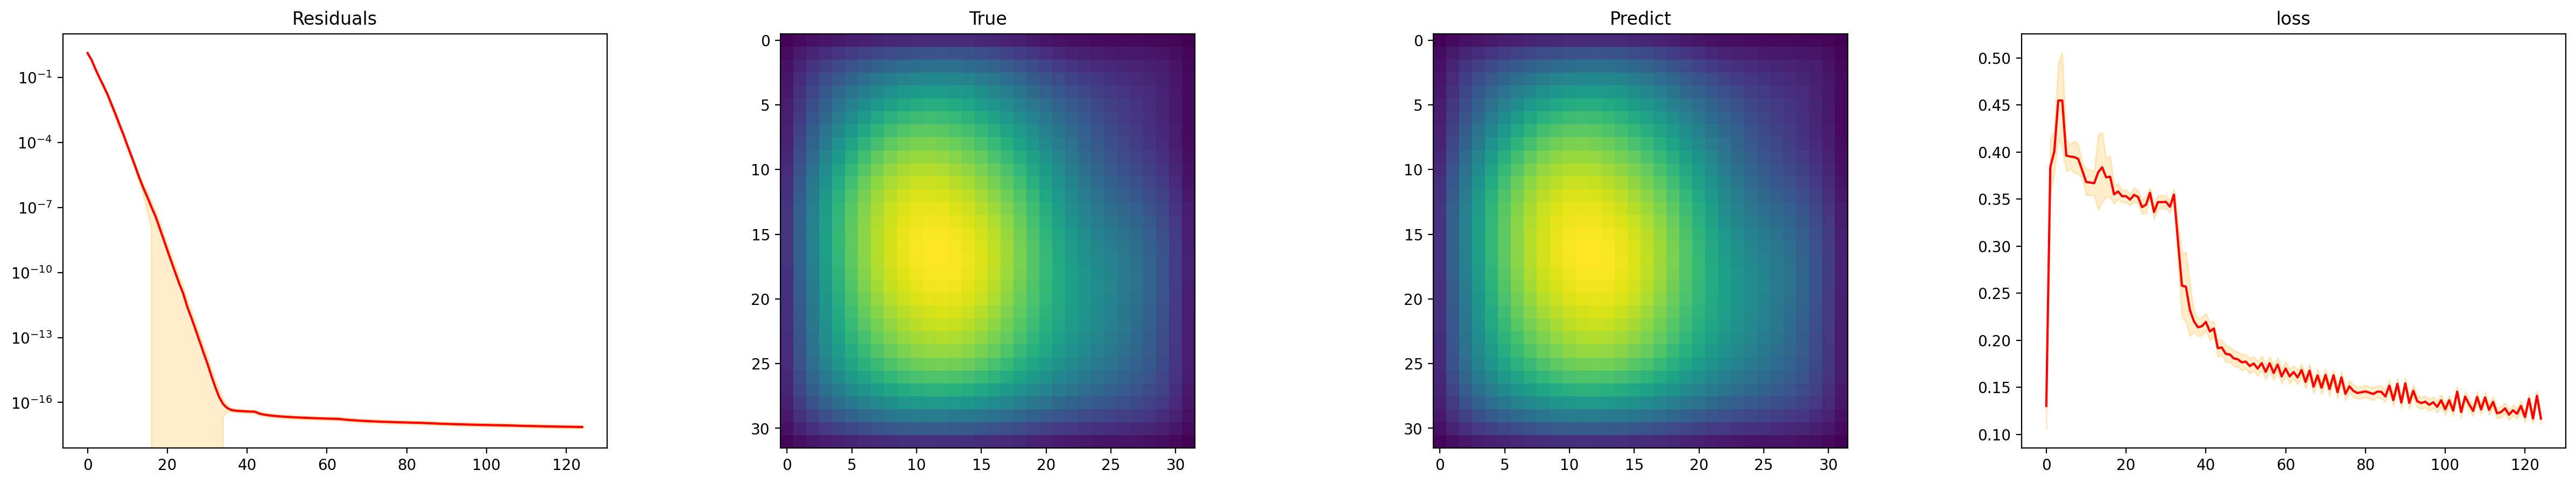

In [16]:
N_iter = 125
m_max = 20
h = 1. / args.grid
N_epochs = 10

optimization_specification['N_epochs'] = N_epochs
optimization_specification['learning_rate'] = 1e-4

_, Ar = scan(spsolve_scan, [A, dataset[0].reshape(-1, args.grid**2)], jnp.arange(A.shape[0]))
Ar = jnp.array(Ar)

P, R, U, X, values, _ = FCG(A, dataset[0].reshape(-1, args.grid**2), Ar.reshape(-1, args.grid**2)*h**2, model, N_iter, m_max, optimization_specification)

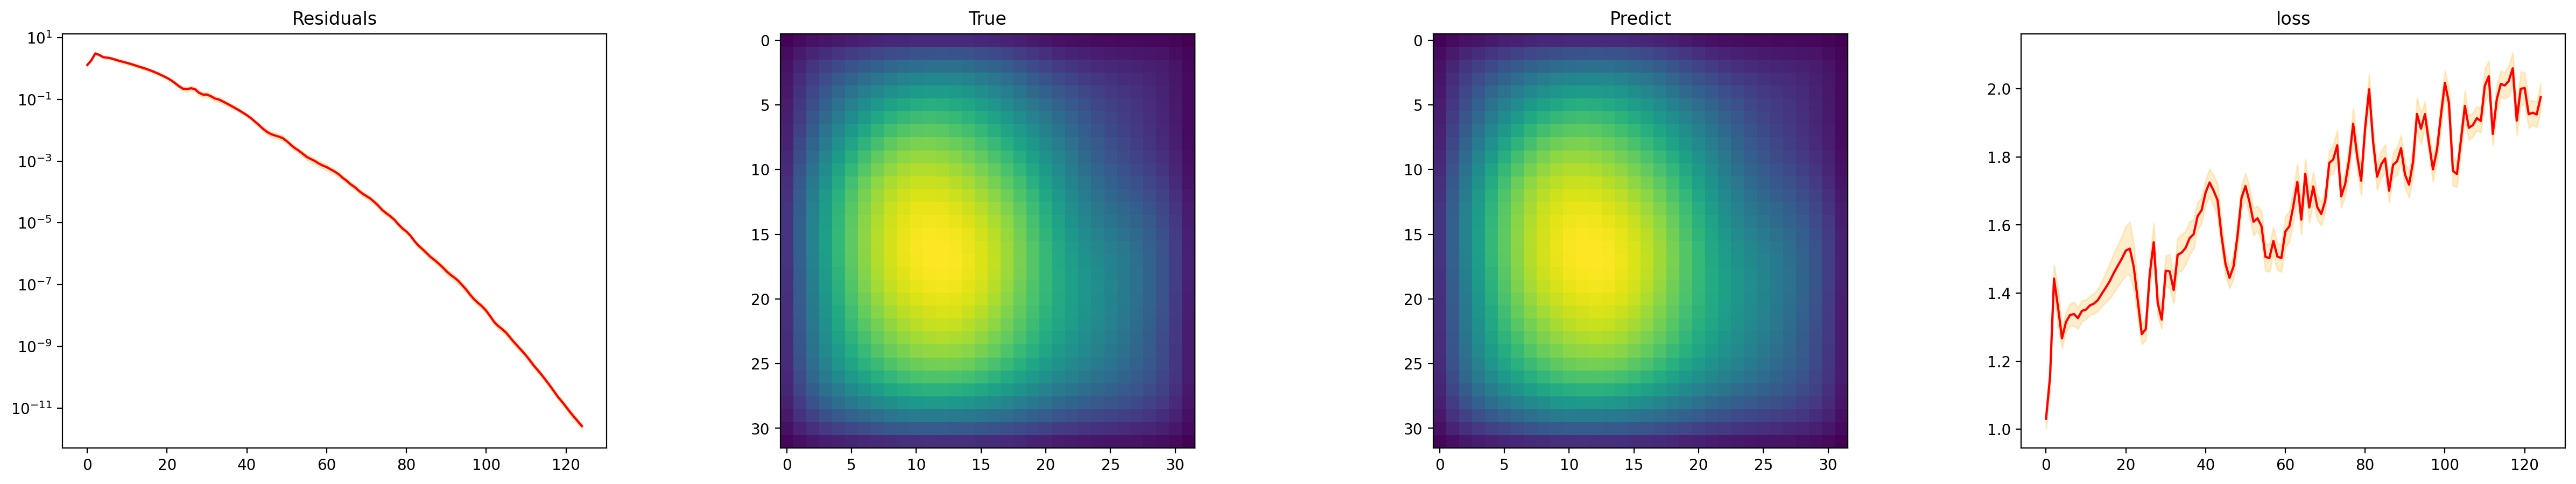

In [17]:
model_ = lambda x: x

P, R_, U, X, values_, _ = FCG(A, dataset[0].reshape(-1, args.grid**2), Ar.reshape(-1, args.grid**2)*h**2, model_, N_iter, m_max, optimization_specification, eps=1e-30)

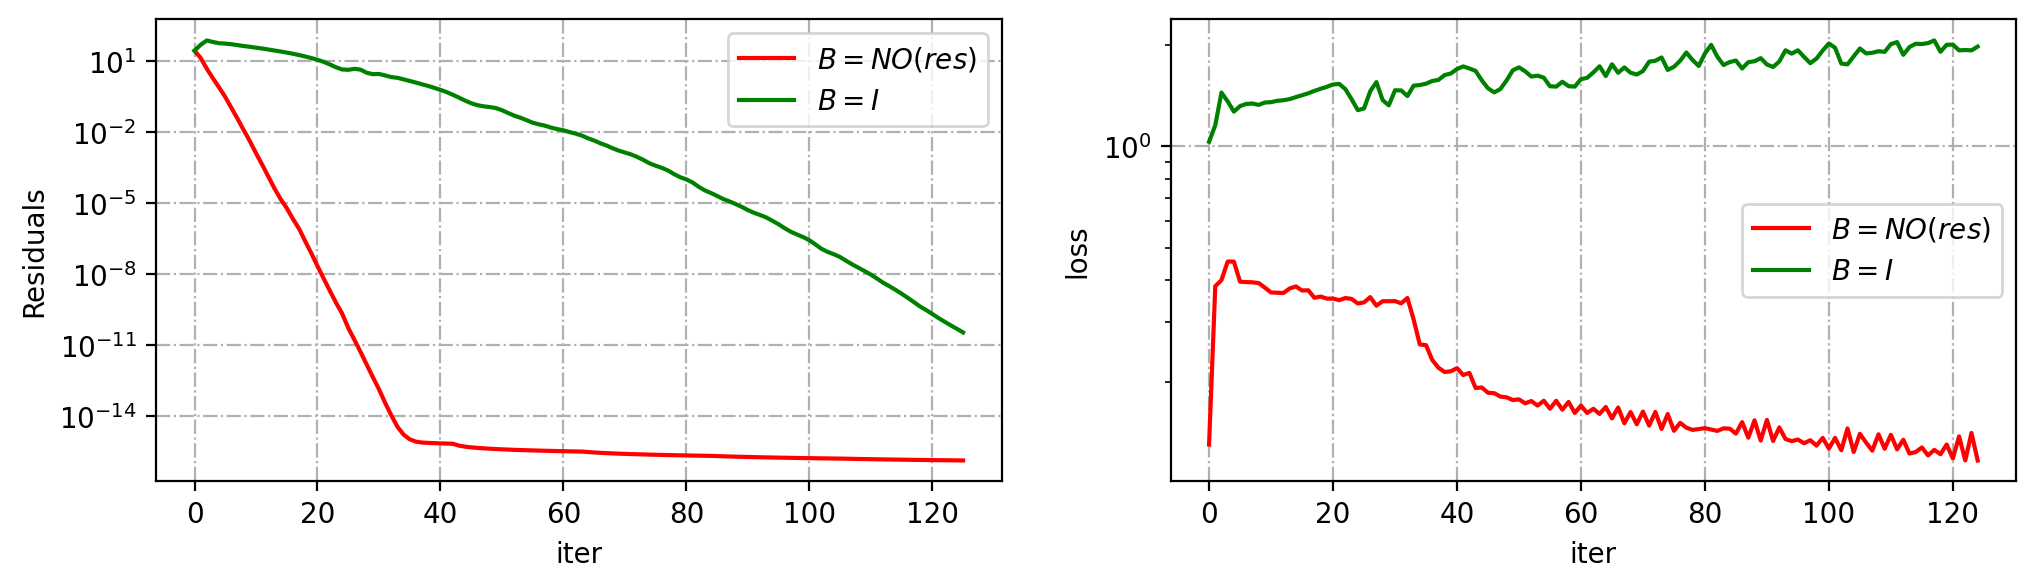

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

ax[0].set_yscale('log')
ax[0].plot(jnp.mean(jnp.linalg.norm(R, axis=1), axis=0), '-', color='red', label=r'$B = NO(res)$')
ax[0].plot(jnp.mean(jnp.linalg.norm(R_, axis=1), axis=0), '-', color='green', label=r'$B = I$')
ax[0].grid(linestyle='-.')
ax[0].set_ylabel(r'Residuals')
ax[0].set_xlabel(r'iter')
ax[0].legend(loc='best');

ax[1].set_yscale('log')
ax[1].plot(values, '-', color='red', label=r'$B = NO(res)$')
ax[1].plot(values_, '-', color='green', label=r'$B = I$')
ax[1].grid(linestyle='-.')
ax[1].set_ylabel(r'loss')
ax[1].set_xlabel(r'iter')
ax[1].legend(loc='best');